<a href="https://colab.research.google.com/github/neuroqudit/pyngn/blob/main/notebooks/05_benchmark_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05. Benchmark & Comparison: Triglial Reservoir vs. MLP

This notebook benchmarks the **Triglial Reservoir** (3GSNN) on the MNIST digit classification task and compares it against a traditional **Multi-Layer Perceptron (MLP)** baseline.

## Models
1.  **Triglial Reservoir (3GSNN)**:
    - **Encoder**: Poisson coding (Pixels -> Spikes).
    - **Reservoir**: Neurons + Astrocytes + Microglia + Delays.
    - **Readout**: Ridge Regression (Closed-form solution).
2.  **Baseline MLP**:
    - **Architecture**: Input -> Hidden (ReLU) -> Output (LogSoftmax).
    - **Training**: Backpropagation (Adam Optimizer).

Both models use the exact same data subset for a fair comparison.

In [ ]:
!pip install pyngn

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

from pyngn.reservoir import TriglialReservoir

%matplotlib inline

## 1. Load Data
We use a subset of MNIST (e.g., 500 samples) to demonstrate performance on limited data.

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download MNIST
train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Use subset for quick benchmark
subset_size = 500
train_subset = Subset(train_data, range(subset_size))
test_subset = Subset(test_data, range(100))

# DataLoaders
# Reservoir processes 1 sample at a time (or small batches if supported)
train_loader_res = DataLoader(train_subset, batch_size=1, shuffle=True)
test_loader_res = DataLoader(test_subset, batch_size=1, shuffle=False)

# MLP processes batches
train_loader_mlp = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader_mlp = DataLoader(test_subset, batch_size=100, shuffle=False)

## 2. Part 1: Triglial Reservoir (3GSNN)

In [13]:
def poisson_encode(image, time_steps=50, gain=10.0):
    pixels = image.view(-1)
    rate = pixels * gain
    prob = torch.clamp(rate * 0.1, 0, 1)
    spikes = torch.rand(time_steps, pixels.shape[0]) < prob.unsqueeze(0)
    return spikes.float()

input_dim = 784
hidden_dim = 100
output_dim = 10

reservoir_model = TriglialReservoir(input_dim, hidden_dim, output_dim,
                                    dt=1.0, max_delay=10,
                                    astro_params={'target_rate': 0.1},
                                    micro_params={'pruning_threshold': 0.3})

print("Triglial Reservoir Initialized")

Triglial Reservoir Initialized


### Train Reservoir Readout

In [14]:
X_train_states = []
Y_train_targets = []

print("Collecting reservoir states...")
for i, (img, label) in enumerate(train_loader_res):
    spikes = poisson_encode(img)

    # Run Reservoir & Get State
    prediction, state = reservoir_model(spikes, return_state=True)

    X_train_states.append(state.squeeze(0))

    target = torch.zeros(10)
    target[label] = 1.0
    Y_train_targets.append(target)

    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1} samples")

X_train = torch.stack(X_train_states)
Y_train = torch.stack(Y_train_targets)

print(f"Training Readout on {X_train.shape[0]} samples...")
reservoir_model.readout.fit(X_train, Y_train)
print("Reservoir Training Complete.")

Processed 100 samples
Processed 200 samples
Processed 300 samples
Processed 400 samples
Processed 500 samples
Training Readout on 500 samples...
Reservoir Training Complete.


### Evaluate Reservoir

In [15]:
res_correct = 0
res_total = 0

print("Evaluating Reservoir...")
with torch.no_grad():
    for img, label in test_loader_res:
        spikes = poisson_encode(img)
        prediction = reservoir_model(spikes)

        predicted_class = torch.argmax(prediction).item()
        if predicted_class == label.item():
            res_correct += 1
        res_total += 1

res_accuracy = res_correct / res_total
print(f"Triglial Reservoir Accuracy: {res_accuracy * 100:.2f}%")

Evaluating Reservoir...
Triglial Reservoir Accuracy: 72.00%


## 3. Part 2: Baseline MLP (PyTorch)

In [16]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=100, output_dim=10):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

mlp_model = SimpleMLP(hidden_dim=hidden_dim)
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("MLP Initialized")

MLP Initialized


### Train MLP

Training MLP on 500 samples for 20 epochs...
Epoch 5/20, Loss: 0.2121
Epoch 10/20, Loss: 0.0583
Epoch 15/20, Loss: 0.0213
Epoch 20/20, Loss: 0.0119


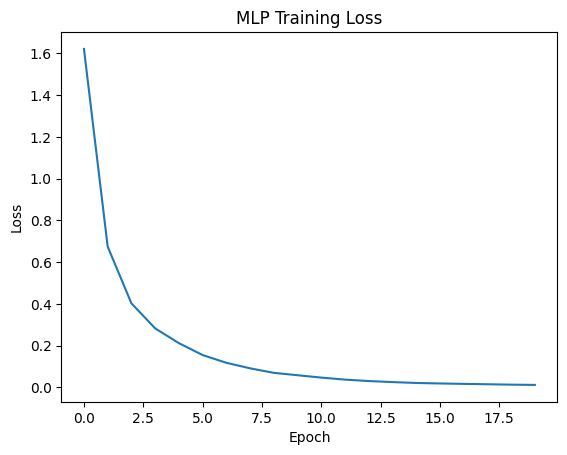

In [17]:
epochs = 20
losses = []

print(f"Training MLP on {subset_size} samples for {epochs} epochs...")

for epoch in range(epochs):
    mlp_model.train()
    epoch_loss = 0
    for data, target in train_loader_mlp:
        optimizer.zero_grad()
        output = mlp_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    losses.append(epoch_loss / len(train_loader_mlp))
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {losses[-1]:.4f}")

plt.plot(losses)
plt.title("MLP Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Evaluate MLP

In [18]:
mlp_model.eval()
mlp_correct = 0
mlp_total = 0

with torch.no_grad():
    for data, target in test_loader_mlp:
        output = mlp_model(data)
        pred = output.argmax(dim=1, keepdim=True)
        mlp_correct += pred.eq(target.view_as(pred)).sum().item()
        mlp_total += target.size(0)

mlp_accuracy = mlp_correct / mlp_total
print(f"Baseline MLP Accuracy: {mlp_accuracy * 100:.2f}%")

Baseline MLP Accuracy: 87.00%


## 4. Comparison Results

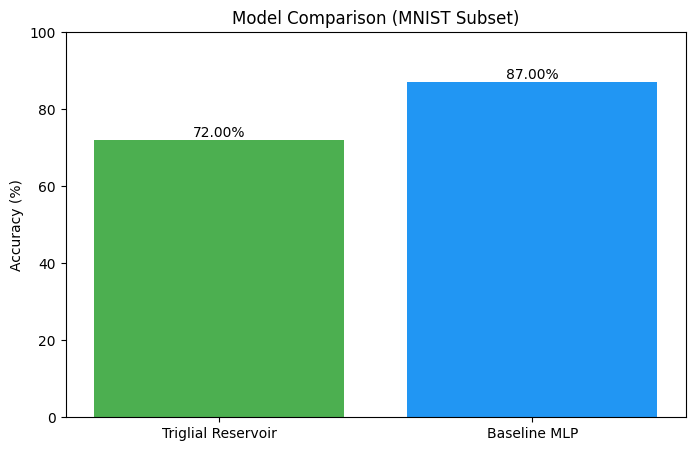

In [19]:
labels = ['Triglial Reservoir', 'Baseline MLP']
accuracies = [res_accuracy * 100, mlp_accuracy * 100]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, accuracies, color=['#4CAF50', '#2196F3'])
plt.ylabel('Accuracy (%)')
plt.title('Model Comparison (MNIST Subset)')
plt.ylim(0, 100)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom')

plt.show()